In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts/ConceptBottleneck/')
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts')

In [3]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
from matplotlib.patches import Circle
import json
import argparse
import logging 
import resource 
import secrets
from torch.utils.data import Subset

In [4]:
from ConceptBottleneck.CUB.dataset import load_data

In [5]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [6]:
torch.cuda.set_per_process_memory_fraction(0.5)
resource.setrlimit(resource.RLIMIT_AS, (20 * 1024 * 1024 * 1024, -1))
torch.set_num_threads(1)

In [7]:
logging.basicConfig(level=logging.INFO)
logging.info("Setting up dataset")

INFO:root:Setting up dataset


In [80]:
is_jupyter = 'ipykernel' in sys.modules
if is_jupyter:
    encoder_model='small7'
    seed = 44
    dataset_name = "synthetic_object/synthetic_2"
    train_variation = "none"
    model_type = "cem"
else:
    parser = argparse.ArgumentParser(description="Synthetic Dataset Experiments")

    parser.add_argument('--seed', type=int, default=42, help='Random seed')
    parser.add_argument('--train_variation', type=str, default='none', help='Which train variation to analyze')
    parser.add_argument('--model_type', type=str, default='joint', help='Which train variation to analyze')

    args = parser.parse_args()
    encoder_model = "inceptionv3" 
    seed = args.seed 
    dataset_name = "synthetic_object/synthetic_2"
    train_variation = args.train_variation
    model_type = args.model_type

parameters = {
    'dataset': dataset_name,
    'seed': seed, 
    'encoder_model': encoder_model ,
    'debugging': False,
    'epochs': 50,
    'lr': 0.05,
    'train_variation': train_variation,
    'model_type': model_type,
    'weight_decay': 0.004, 
    'scale_lr': 5
}


In [81]:
train_loader, val_loader, test_loader, train_pkl, val_pkl, test_pkl = get_data(1,encoder_model=encoder_model,dataset_name=dataset_name)

In [82]:
train_pkl[0]

{'id': 0,
 'img_path': 'synthetic_object/synthetic_2/images/0.png',
 'class_label': 1,
 'attribute_label': [0, 1, 1, 0]}

In [83]:
reference_pkl = [
    {'id': 0, 'img_path': 'synthetic_object/synthetic_2/reference_images/1_0_0_0.png','class_label': 0, 'attribute_label': [1,0,0,0]},
    {'id': 1, 'img_path': 'synthetic_object/synthetic_2/reference_images/0_1_0_0.png','class_label': 1, 'attribute_label': [0,1,0,0]},
    {'id': 2, 'img_path': 'synthetic_object/synthetic_2/reference_images/0_0_1_0.png','class_label': 0, 'attribute_label': [0,0,1,0]},
    {'id': 3, 'img_path': 'synthetic_object/synthetic_2/reference_images/0_0_0_1.png','class_label': 0, 'attribute_label': [0,0,0,1]}
]

In [84]:
pickle.dump(reference_pkl,open("../../../../datasets/synthetic_object/synthetic_2/preprocessed/reference.pkl","wb"))

In [85]:
reference_image_path = "../../../../datasets/synthetic_object/synthetic_2/preprocessed/reference.pkl"
resize =  "inceptionv3" in encoder_model
get_label_free=False 
reference_loader = load_data([reference_image_path], True, no_img=False, batch_size=64, image_dir="reference_images/", n_class_attr=2, path_transform=lambda path: "../../../../datasets/"+path,resize=resize,get_label_free=get_label_free)


In [86]:
test_images, test_y, test_c = unroll_data(test_loader)

In [87]:
reference_images, references_y, references_c = unroll_data(reference_loader)

In [88]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [89]:
parameters

{'dataset': 'synthetic_object/synthetic_2',
 'seed': 44,
 'encoder_model': 'small7',
 'debugging': False,
 'epochs': 50,
 'lr': 0.05,
 'train_variation': 'none',
 'model_type': 'cem',
 'weight_decay': 0.004,
 'scale_lr': 5}

In [90]:
if model_type != 'joint':
    joint_model = get_synthetic_model(dataset_name,{'model_type': model_type, 'dataset': 'synthetic_2', 'seed': seed})
else:
    joint_model = get_synthetic_model(dataset_name,parameters)
joint_model = joint_model.to(device)


['a4aa87e7']


In [91]:
run_model_function = run_joint_model
if model_type == "cem":
    run_model_function = run_cem_model
elif model_type == "probcbm":
    run_model_function = run_probcbm_model

## Plot the Dataset

In [92]:
logging.info("Plotting Dataset")

INFO:root:Plotting Dataset


In [93]:
dataset_directory = "../../../../datasets"

In [94]:
train_pkl[0]

{'id': 0,
 'img_path': 'synthetic_object/synthetic_2/images/0.png',
 'class_label': 1,
 'attribute_label': [0, 1, 1, 0]}

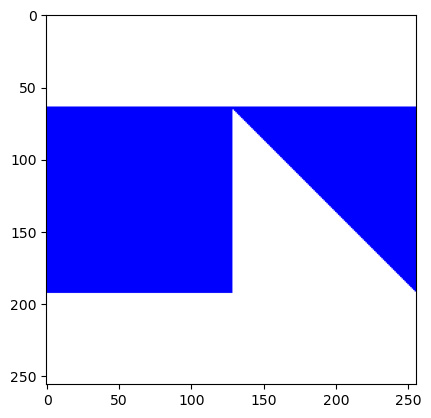

In [95]:
img_path = dataset_directory+'/'+train_pkl[0]['img_path']
image = Image.open(img_path)
plt.imshow(image)

## Accuracy

In [96]:
train_acc =  get_accuracy(joint_model,run_model_function,train_loader)
val_acc = get_accuracy(joint_model,run_model_function,val_loader)
test_acc = get_accuracy(joint_model,run_model_function,test_loader)

In [97]:
train_acc, val_acc, test_acc

(1.0, 1.0, 1.0)

In [98]:
with torch.no_grad():

    for data_point in reference_loader:
        x,y,c = data_point 
        _, reference_predictions = run_model_function(joint_model,x.to(device))
        reference_predictions = torch.nn.Sigmoid()(reference_predictions.detach().cpu().T)
    
relevant_mask = []
for concept in range(2):
    for data_point in [[1,0,1,0],[1,0,0,1],[0,1,1,0],[0,1,0,1]]:
        if concept == 0:
            initial_idx = data_point[:2].index(1)
        else:
            initial_idx = data_point[2:].index(1)+2
        data_point[initial_idx] = 0
        new_prediction = reference_predictions[data_point.index(1)][initial_idx]
        relevant_mask.append(1-new_prediction)

irrelevant_mask = []
for concept in range(2):
    for data_point in [[1,0,1,0],[1,0,0,1],[0,1,1,0],[0,1,0,1]]:
        if concept == 0:
            initial_idx = data_point[:2].index(1)
            other_idx = data_point[2:].index(1)+2
        else:
            initial_idx = data_point[2:].index(1)+2
            other_idx = data_point[:2].index(1)
        data_point[other_idx] = 0
        new_prediction = reference_predictions[data_point.index(1)][initial_idx]
        irrelevant_mask.append(1-new_prediction)

In [99]:
np.mean(relevant_mask), np.mean(irrelevant_mask)

(0.38083738, 0.33956942)

In [139]:
results = {
    'relevant_mask': relevant_mask,
    'irrelevant_mask': irrelevant_mask,
    'parameters': {
        'seed': seed, 
        'dataset': 'synthetic_object/synthetic_2', 
        'train_variation': train_variation, 
        'model_type': model_type, 
    }, 
}

In [100]:
[0.38211682,0.37825048, 0.38083738],[0.36970115, 0.35567003, 0.33956942]

([0.38211682, 0.37825048, 0.38083738], [0.36970115, 0.35567003, 0.33956942])

In [103]:
np.mean([0.36970115, 0.35567003, 0.33956942]), np.std([0.36970115, 0.35567003, 0.33956942])

(0.35498019999999997, 0.012310894559153681)

In [327]:
np.std([0.33209044, 0.3269265, 0.3267908])

0.002466911585660628

In [184]:
np.mean([0,0.0846944,0.07229926]),np.std([0,0.0846944,0.07229926])

(0.052331220000000005, 0.03734815759776467)